In [42]:
import os
import rasterio as rio
import numpy as np
import geopandas as gpd
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from progressbar import ProgressBar

plt.rcParams["figure.figsize"] = (28,10)
plt.ion()

In [18]:
data_dir = 'data_100m'

dem_file            = f'{data_dir}/dem.tif'
slope_file          = f'{data_dir}/slope.tif'
aspect_file         = f'{data_dir}/aspect.tif'
northing_file       = f'{data_dir}/northing.tif'
easting_file        = f'{data_dir}/easting.tif'

urban_distance_file = f'{data_dir}/Urbano.tiff'
roads_distance_file = f'{data_dir}/Strade.tiff'
crops_distance_file = f'{data_dir}/Coltivo.tiff'

vegetation_agg_file = f'{data_dir}/vegetation_agg.tiff'
vegetation_file     = f'{data_dir}/vegetation.tiff'

fires_shp           = 'shapefiles/perimetrazioni_1997_2017.shp'
vegetation_shp      = 'shapefiles/tipiforestali_usosuolo_ctr_fv.shp'

In [3]:
with rio.open(dem_file) as src:
    print(f'Reading dem file {dem_file}')
    dem = src.read(1)
    dem[dem <= -9999] = np.NaN
_, dx, _, _, _, dy = src.transform.to_gdal()    

Reading dem file data_100m/dem.tif


## PREPROCESSING

In [4]:
from sklearn import preprocessing
from rasterio import features

from shapely.geometry import Point, GeometryCollection

def extract_coordinates(indices, src):
    indices_t = indices.T[::-1, :]

    coordinates = np.stack(src.transform * indices_t)

    _, dx, _, _, _, dy = src.transform.to_gdal()
    coordinates = coordinates + np.array([[dx, dy]]).T/2

    #points = [Point(*p) for p in coordinates.T]

    return coordinates


def encode_feature(gdf, column):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(gdf[column])
    encoded_column = encoder.transform(gdf[column])
    mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_,))
    return encoded_column, mapping


def rasterize_numerical_feature(gdf, column, reference_file):
    with rio.open(reference_file) as f:
        out = f.read(1)
        out_array = np.empty(out.shape)
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf[column]))

        burned = features.rasterize(shapes=shapes, fill=np.NaN, out=out_array, transform=f.transform)
    #    out.write_band(1, burned)

    return burned

def save_raster_as(array, output_file, reference_file, **kwargs):
    with rio.open(reference_file) as f:
        profile = f.profile
        profile.update(**kwargs)

        with rio.open(output_file, 'w', **profile) as dst:
            dst.write(array.astype(profile['dtype']), 1)
            
def read_tiff(tiff_file):
    with rio.open(tiff_file) as f:
        print(f'Reading file {tiff_file}')        
        data = f.read(1)
    return data

In [5]:
def calculate_box_grid(bbox, dx, dy, box_dim):
    lon_min, lon_max, lon_step = bbox.left   +dx/2 + box_dim/2, bbox.right +dx/2 - box_dim/2, box_dim
    lat_min, lat_max, lat_step = bbox.bottom +dy/2 + box_dim/2, bbox.top   +dy/2 - box_dim/2, box_dim
    return lon_min, lon_max, lon_step, lat_min, lat_max, lat_step


def build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step):
    box_lon = np.arange(lon_min, lon_max +lon_step/2, lon_step)
    box_lat = np.arange(lat_min, lat_max +lat_step/2, lat_step)
    box_lons, box_lats = np.meshgrid(box_lon, box_lat)

    return box_lons, box_lats
    
def get_boxes_rc(coordinates, lon_min, lon_step, lat_min, lat_step):
    C = (np.round((coordinates[0, :] - lon_min) / lon_step)).astype('int')
    R = (np.round((coordinates[1, :] - lat_min) / lat_step)).astype('int')
    RC = np.array((R, C))
    return RC

def calculate_box_intersections(selected_features, box_lons, box_lats, RC):
    unique_rc = np.unique(RC, axis=1)

    box_cuts = {}
    bar = ProgressBar()
    for rc in bar(unique_rc.T):
        lon, lat = box_lons[rc[0], rc[1]], box_lats[rc[0], rc[1]]
        box = Point(lon, lat).buffer(box_dim + buffer_dim).envelope
        box_cut = [box.intersection(g) for g in selected_features.geometry]
        box_cuts[(rc[0], rc[1])] = box_cut
    
    return box_cuts

def calculate_distances_on_boxes(coordinates, RC, box_cuts, outside_value=-9999):
    bar = ProgressBar()
    distances = []
    points = []
    for p, rc in bar(zip(coordinates.T, RC.T)):
        point = Point(*p)
        p_distances = [
            point.distance(g) 
            if not g.is_empty 
            else np.NaN 
            for g in box_cuts[(rc[0], rc[1])]
        ] 
        d = np.nanmin(p_distances)
        d = outside_value if d > buffer_dim else d
        distances.append(d)
        points.append(point)
        
    return distances, points

In [6]:
with rio.open(dem_file) as src:
    print(f'Reading dem file {dem_file}')
    dem = src.read(1)
    dem[dem <= -9999] = np.NaN

if not os.path.isfile(slope_file):
    print(f'Creating slope file {slope_file}')
    gdal.DEMProcessing(slope_file, dem_file, 'slope')

    
if not os.path.isfile(northing_file) or not os.path.isfile(easting_file):

    if not os.path.isfile(aspect_file):
        print(f'Creating aspect file {aspect_file}')
        gdal.DEMProcessing(aspect_file, dem_file, 'aspect')

    with rio.open(aspect_file) as f:
        print(f'Calculating northing and easting files')
        print(f'Reading aspect file {aspect_file}')
        aspect = f.read(1)
        aspect[aspect <= -9999] = np.NaN    
        northing = np.cos(aspect * np.pi/180.0)
        easting = np.sin(aspect * np.pi/180.0)

    print(f'Saving northing file {northing_file}')
    save_raster_as(northing, northing_file, aspect_file)
    print(f'Saving easting file {easting_file}')    
    save_raster_as(easting, easting_file, aspect_file)

Reading dem file data_100m/dem.tif


In [7]:
print(f'Reading vegetation shp {vegetation_shp}')
vegetation = gpd.read_file(vegetation_shp)
vegetation['encoded_decodifica'], mapping = encode_feature(vegetation, 'Decodifica')    

if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation')
    vegetation_raster = rasterize_numerical_feature(vegetation, 'encoded_decodifica', dem_file)
    print(f'Writing vegetation_raster file {vegetation_agg_file}')    
    save_raster_as(vegetation_raster, vegetation_file, dem_file)
    

if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation_agg')    
    vegetation_agg_raster = rasterize_numerical_feature(vegetation, 'id_agg_fv', dem_file)
    print(f'Writing vegetation_agg_raster file {vegetation_agg_file}')
    save_raster_as(vegetation_agg_raster, vegetation_agg_file, dem_file)
    
if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation_agg')    
    vegetation_agg_raster = rasterize_numerical_feature(vegetation, 'id_agg_fv', dem_file)
    print(f'Writing vegetation_agg_raster file {vegetation_agg_file}')
    save_raster_as(vegetation_agg_raster, vegetation_agg_file, dem_file)    

Reading vegetation shp shapefiles/tipiforestali_usosuolo_ctr_fv.shp


In [7]:
mask = vegetation_raster > 0
indices = np.argwhere(mask)
coordinates = extract_coordinates(indices, src)

In [8]:
bbox = src.bounds
box_dim = 10000.0
buffer_dim = 3000.0

In [9]:
distance_types = 'Strade', 'Coltivo', 'Urbano'

for distance_type in distance_types:
    distance_file = f'{data_dir}/{distance_type}.tiff'

    if not os.path.isfile(distance_file):
        print(f'Calculating distance {distance_type}')        
        selected_features = vegetation.query(f'{distance_type} == 1')

        lon_min, lon_max, lon_step, lat_min, lat_max, lat_step = calculate_box_grid(bbox, dx, dy, box_dim)
        box_lons, box_lats = build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step)
        RC = get_boxes_rc(coordinates, lon_min, lon_step, lat_min, lat_step)
        box_cuts = calculate_box_intersections(selected_features, box_lons, box_lats, RC)

        distances, points = calculate_distances_on_boxes(coordinates, RC, box_cuts)

        data = np.empty_like(dem)
        data[mask] = distances
        
        print(f'Writing distance file {distance_file}')
        save_raster_as(data, distance_file, dem_file)
        

## DATA PREPARATION

In [10]:
print(f'Reading northing file {slope_file}')
slope = read_tiff(slope_file)

print(f'Reading northing file {northing_file}')
northing = read_tiff(northing_file)
    
print(f'Reading easting file {easting_file}') 
easting = read_tiff(easting_file)

print(f'Reading vegetation_raster file {vegetation_file}')            
vegetation_raster = read_tiff(vegetation_file)
    
print(f'Reading vegetation_agg_raster file {vegetation_agg_file}')          
vegetation_agg_raster = read_tiff(vegetation_agg_file)

print(f'Reading urban distance file {urban_distance_file}')
urban_distance = read_tiff(urban_distance_file)

print(f'Reading roads distance file {roads_distance_file}')
roads_distance = read_tiff(roads_distance_file)

print(f'Reading roads distance file {crops_distance_file}')
crops_distance = read_tiff(crops_distance_file)

Reading northing file data_100m/slope.tif
Reading file data_100m/slope.tif
Reading northing file data_100m/northing.tif
Reading file data_100m/northing.tif
Reading easting file data_100m/easting.tif
Reading file data_100m/easting.tif
Reading vegetation_raster file data_100m/vegetation.tiff
Reading file data_100m/vegetation.tiff
Reading vegetation_agg_raster file data_100m/vegetation_agg.tiff
Reading file data_100m/vegetation_agg.tiff
Reading urban distance file data_100m/Urbano.tiff
Reading file data_100m/Urbano.tiff
Reading roads distance file data_100m/Strade.tiff
Reading file data_100m/Strade.tiff
Reading roads distance file data_100m/Coltivo.tiff
Reading file data_100m/Coltivo.tiff


In [11]:
print(f'Reading vegetation shp {vegetation_shp}')
vegetation = gpd.read_file(vegetation_shp)
vegetation['encoded_decodifica'], mapping = encode_feature(vegetation, 'Decodifica')

Reading vegetation shp shapefiles/tipiforestali_usosuolo_ctr_fv.shp


In [44]:
# masking vegetation raster excluding non-vegetated areas
mask = vegetation_agg_raster >= 20
indeces = np.argwhere(mask)
coordinates = extract_coordinates(indeces, src)
points_geom = [Point(*p) for p in coordinates.T]

points = gpd.GeoDataFrame(pd.DataFrame(indeces, columns=['row', 'col']), geometry=points_geom, crs={'init': 'epsg:3003'})

In [45]:
points_envelope_df = points_df.copy()
points_envelope_df.geometry = points_df.geometry.buffer(dx/2).envelope

In [46]:
print(f'Reading fires shp {fires_shp}')
fires = gpd.read_file(fires_shp)

In [53]:
train_fires = fires.query('anno < 2013')
test_fires = fires.query('anno >= 2013')

In [54]:
train_fp = gpd.sjoin(points_envelope_df, train_fires)
test_fp = gpd.sjoin(points_envelope_df, test_fires)

In [49]:
absence_idx = ~points_df.index.isin(train_fp.index_right)
absence_df = points_df.iloc[points_df.index[absence_idx]]

In [56]:
data_dict = {
    'slope': slope,
    'northing': northing,
    'easting': easting,
    'vegetation': vegetation_raster,
    'vegetation_agg': vegetation_agg_raster,
    'urban_distance': urban_distance,
    'roads_distance': roads_distance,
    'crops_distance': crops_distance
}

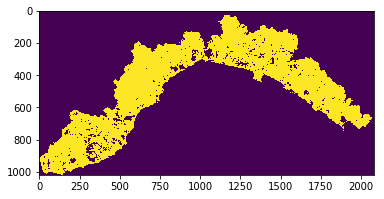

In [82]:
plt.imshow(mask_absence)